# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/demo_202107/demo_utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = False
ENABLE_DETECT = False
ENABLE_O3D = True

CONNECT_INDY = False
CONNECT_MOBILE = False

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.15, 0.32]
TOOL_THICKNESS = 0.05
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

COL_COLOR = (1,1,1,0.2)

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
if CONNECT_TASK_PLANNER:
    from demo_proto.TaskExecuteServer import serve_on_thread
    servicer = serve_on_thread()

In [3]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7kiro, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform")
ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[CONNECT_MOBILE, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 12, -7, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=CAM_LINK, center=(-0.0785, 0, 0.073))

add_brush(gscene, face_name=TOOL_NAME, tool_link=TIP_LINK,
          thickness=TOOL_THICKNESS, tool_dim=TOOL_DIM,
          col_color=COL_COLOR)

HOME_POSE = crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=0.5, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(ROBOT_TYPE, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']
crob.simulator.set_gscene(gscene)

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_CAM:
    camgen = CameraGenerator()

connection command:
kmb0: False
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7kiro-frontX-PRQ.pkl
Loaded: indy7kiro-upZ-PRQ.pkl
Loaded: indy7kiro-downZ-PRQ.pkl


#### [DataRecon]

In [4]:
from demo_utils.data_reconstructed_camera import DataRecontructedCamera
dcam = DataRecontructedCamera(crob, viewpoint)

if not CONNECT_CAM:
    dcam.initialize()

#### 0.1.2 Load environment map

In [5]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT
kmb.gscene = gscene

kmm.init_node(timeout=10)

In [6]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)
if not CONNECT_MOBILE:
    crob.joint_move_make_sure(kmm.Q_map)

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [7]:
from demo_utils.detection_util_bak import *
from demo_utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

In [8]:
if CONNECT_TASK_PLANNER:
    while servicer.object_info_running.object_id < 0:
        time.sleep(1)

#### 1.1.1 Move to bed-seek pose 

In [9]:
Q_CUR = crob.get_real_robot_pose()

VIEW_POSE = crob.home_pose[6:]
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
crob.joint_move_make_sure(VIEW_POSE_EXT)

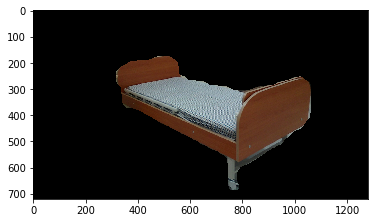

In [10]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="bed", crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    turn_dir *= -1
    dQ = np.add(dQ, [5,0,0,0,0,0])
    Qto = Q0+turn_dir*dQ
    Qto[0] = (Qto[0]+180/2)%180-180/2
    indy.joint_move_make_sure(np.deg2rad(Qto))
    VIEW_POSE_EXT[6:] = indy.get_qcur()

#### [DataRecon]

In [11]:
if CONNECT_CAM:
    color, depth, intrins, depth_scale = \
        rdict['color'], rdict['depth'], rdict['intrins'], rdict['depth_scale']
    cameraMatrix, _ = intrins2cammat(intrans)
    distCoeffs = [0]*5
    dcam.ready_saving(cameraMatrix=cameraMatrix, 
                      distCoeffs=distCoeffs, depth_scale=depth_scale)
    cam_pose = viewpoint.get_tf(VIEW_POSE_EXT)
    dcam.save_scene(color, depth, cam_pose)

#### 1.1.2  detect bed and add to the scene

In [12]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [13]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None, ratio=0.2)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi/2)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.5,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
    Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
    if Tmo[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.371429e-01, inlier_rmse=6.269699e-02, and correspondence_set size of 6068
Access transformation to get result.
Transformation is:
[[ 0.75868232 -0.07407943  0.64723516 -1.04547283]
 [-0.30479765 -0.91842957  0.25216158  0.29224212]
 [ 0.57575991 -0.38858629 -0.71937551  3.39677865]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[-0.79231258  0.30696011 -0.52727248  1.89469503]
 [-0.10569514 -0.92020797 -0.37688967  1.52997639]
 [-0.60089044 -0.24288

In [14]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
Tbm = gscene.get_tf(MOBILE_BASE, VIEW_POSE_EXT)
Tmo = np.matmul(SE3_inv(Tbm), T_bo_new)
if Tmo[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.427067e-01, inlier_rmse=3.688556e-02, and correspondence_set size of 3044
Access transformation to get result.
Transformation is:
[[ 0.76495732 -0.05845531  0.64142286 -1.03185536]
 [-0.27541695 -0.92991887  0.24371366  0.33582031]
 [ 0.58222485 -0.36308925 -0.72744783  3.4229721 ]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [15]:
VIEW_MOVED = np.deg2rad([  0., 60.,  -60.,  -0.,  -100., 0, 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_refs = [150]
elif CLOSET_LOCATION == "RIGHT":       
    angle_refs = [-150]
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3
for angle_ref in angle_refs:
    for _ in range(100):
        angle_view = angle_ref + np.random.uniform(-10, 10)
        dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/4
        Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
        Tbs = np.matmul(Tbs, 
                        SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
        Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                        SE3(np.identity(3), (-dist_view, 0,0)))
        Tbc = np.matmul(Tbs, Tsc)
        Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
        Tmc[:3,:3] = np.identity(3)
        Tbm = np.matmul(Tbc, SE3_inv(Tmc))
        full_view_ext = np.copy(VIEW_POSE_EXT)
        full_view_ext[:2] = Tbm[:2,3]
        full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
        gscene.show_pose(full_view_ext)
        res = kmb.check_valid(full_view_ext[:6])
        if res:
            VIEW_MOVED_EXT = full_view_ext
            print("Full view loc: {}".format(np.round(VIEW_MOVED_EXT[:3], 2)))
            break
    if res:
        break

CLOSET on LEFT
Full view loc: [ 6.71 -2.03 -2.16]


##### move to full view pose

In [16]:
crob.joint_move_make_sure(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

VIEW_MOVED_EXT: [ 6.71 -2.03 -2.16  0.    0.    0.    0.    1.05 -1.05 -0.   -1.75  0.
  0.  ]


#### 1.2.2 redetect bed

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.648413e-01, inlier_rmse=6.021419e-02, and correspondence_set size of 4959
Access transformation to get result.
Transformation is:
[[-0.99357864  0.10767061  0.03476383  5.2351343 ]
 [ 0.03360867 -0.01252531  0.99935658 -4.75470636]
 [ 0.10803677  0.99410772  0.00882621 -0.07628851]
 [ 0.          0.          0.          1.        ]]


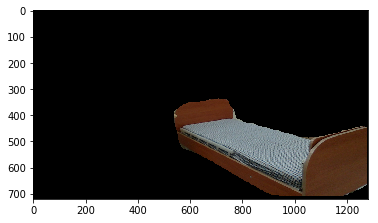

In [17]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = camgen.stream_capture_image(obj_type="full_view", crob=crob)
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    crob.joint_move_make_sure(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc, ratio=0.2)
    T_bs_pre = gscene.NAME_DICT["bed"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### [DataRecon]

In [18]:
if CONNECT_CAM:
    color, depth, = rdict['color'], rdict['depth']
    cam_pose = viewpoint.get_tf(crob.get_real_robot_pose())
    dcam.save_scene(color, depth, cam_pose)

#### 1.2.3  detect and add closet

In [19]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image(obj_type="top_table", crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Apply point-to-point ICP
registration::RegistrationResult with fitness=3.356974e-01, inlier_rmse=1.788463e-02, and correspondence_set size of 568
Access transformation to get result.
Transformation is:
[[ 7.11186921e-02  3.40702804e-02  9.96885852e-01  5.42716706e+00]
 [ 9.97464052e-01  3.42211222e-04 -7.11716370e-02 -4.77071913e+00]
 [-2.76598315e-03  9.99419381e-01 -3.39595423e-02  4.54785499e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [20]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

In [21]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


#### [Test/Remove mismatch]

In [24]:
idc_mis = []
for idx in range(len(dcam.cam_pose_list)):
    color, depth = dcam.color_depth_list[idx]
    Tbc = dcam.cam_pose_list[idx]
    pcd = cdp2pcd(
        ColorDepthMap(color, depth, 
                      cammat2intrins(dcam.cameraMatrix, tuple(reversed(color.shape[:2]))),
                      dcam.depth_scale), depth_trunc=10.0)
    points_c = np.matmul(pcd.points, Tbc[:3,:3].transpose())+ Tbc[:3,3]
    ptem = gscene.show_point_cloud(points_c, "pcd{:03}".format(idx), sample_to=1e5, point_size=0.01,
                           color=(0,0,1,0.5))
    gscene.add_highlight_axis("hl", "tbc", T=Tbc, dims=(0.3,0.03,0.03))
    cmd = raw_input()
    if cmd == 'n':
        gscene.remove(ptem)
        idc_mis.append(idx)
    elif cmd == 'x':
        break
    else:
        print("ok")
        gscene.show_point_cloud(points_c, "pcd{:03}".format(idx), sample_to=1e5, point_size=0.01,
                               color=(0,1,0,0.5))
print("idc to remove: {}".format(idc_mis))
gscene.clear_highlight()

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
n
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
n
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.

ok
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.

ok
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.

ok
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.

ok
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
n
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.
n
[WARN] Vertices for mesh should be have 

In [22]:
idc_remove = [0, 1, 6, 7]
dcam.cam_pose_list = list(dcam.cam_pose_list)
for idx in reversed(idc_remove):
    dcam.cam_pose_list.pop(idx)
    dcam.color_depth_list.pop(idx)
dcam.cam_pose_list = np.array(dcam.cam_pose_list)

for gname in deepcopy(gscene.NAME_DICT.keys()):
    if "pcd" in gname:
        gscene.remove(gscene.NAME_DICT[gname])  

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off



## 2. Prepare cleaning

In [ ]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [ ]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

In [ ]:
adjust_count_list = []
THRESH = 0.05
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    Qref_in = np.copy(Qref)
    Qref = np.copy(Qref)
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=CAM_LINK,
                                     cam_link=CAM_LINK,
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = camgen.stream_capture_image( 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     crob=crob)
        color, depth = rdict['color'], rdict['depth']
    else:
        color, depth = dcam.get_image_depthmap()
        rdict = {"color": color, "depth": depth, "depth_scale": dcam.depth_scale,
                 "intrins": cammat2intrins(dcam.cameraMatrix, img_dim=tuple(reversed(depth.shape[:2])))
                }
    
    Qcur = crob.get_real_robot_pose()
    Tcur = viewpoint.get_tf(Qcur)
    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, Tcur)
    ptem0 = gscene.show_point_cloud(pcd_closet.points, "pcd_sens", sample_to=1e5, point_size=0.01,
                           color=(0,1,0,0.5))

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")
    ptem1 = gscene.show_point_cloud(pcd_masked.points, "pcd_mask", sample_to=1e5, point_size=0.01,
                           color=(1,0,0,0.5))

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.2)

    initial_guess = gscene.NAME_DICT["closet"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close1, fitness1 = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=THRESH, visualize=VISUALIZE)
        T_bo_close = T_bo_close1
#         T_bo_close2, fitness2 = icp_closet.compute_front_ICP(
#             T_bc, initial_guess, thres=THRESH*2, visualize=VISUALIZE)
#         T_bo_close = T_bo_close1 if fitness1 > fitness2 else T_bo_close2

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)
    
    Qcur = np.copy(Qref)
    Qcur[:2] = Tbw1[:2,3]
    Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

    ######################################
    ############# DATA RECON #############
    ######################################
    if CONNECT_CAM:
        TextColors.RED.println("[DATA SAVING FOR RECONSTRUCTION]")
        color, depth, = rdict['color'], rdict['depth']
        cam_pose = viewpoint.get_tf(Qcur)
        dcam.save_scene(color, depth, cam_pose)
    ######################################
    ############# DATA RECON #############
    ######################################
    Qadj_cur = crob.get_real_robot_pose()
    Qadj_cur[:2] = Tbw1[:2,3]
    Qadj_cur[2] = Rot2axis(Tbw1[:3,:3], 3)
    pcd_adj = cdp2pcd(cdp, viewpoint.get_tf(Qadj_cur))
    ptem2 = gscene.show_point_cloud(pcd_adj.points, "pcd_adj", sample_to=1e5, point_size=0.01,
                           color=(0,0,1,0.5))
    
    if CONNECT_CAM and CONNECT_MOBILE:

        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    else:
        Qcur = np.copy(Qref_in)
        Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
        
        Qtar = np.copy(Qref_in)
        Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
    return Qcur, Qtar

In [ ]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

## 3. Bed cleaning

In [ ]:
VISUALIZE=False

In [ ]:
T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.02, margin=0.05)
gscene.add_virtual_guardrail(closet_down, HEIGHT=0.02, margin=0.05, axis="xy")

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

covereds_all = []
for _ in range(1):
    gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
    gxter.init_base_divs(Qcur)
    # gxter.mark_tested(None, None, covereds_all, [])
    snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
        Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, covereds=covereds_all)
    covereds_all = sorted(set(covereds_all+covereds))
    gxter.test_clear()
    len_covered, len_all = len(covereds_all), len(gxter.surface_div_centers)
    print("########################### TRIAL ONCE DONE ( {} / {} )########################".format(len_covered, len_all))
    if len_covered >= len_all:
        break
    print(gtimer)
gscene.clear_virtuals()

## 4. Closet cleaning

In [ ]:
VISUALIZE = False

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_rightup, HEIGHT=0.2, margin=0.15)
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*1.5, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(closet_leftup, HEIGHT=0.1, margin=0.1)
tplan.node_trial_max = NODE_TRIAL_MAX

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(
    Qcur, 1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

In [ ]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.05, margin=0.1, axis="xy")
tplan.node_trial_max = NODE_TRIAL_MAX * 2

gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                      timeout=TIMEOUT_MOTION*2, timeout_loop=TIMEOUT_FULL, 
                      verbose=VERBOSE, max_solution_count=MAX_SOL_NUM)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(
    Qcur, -1, mode_switcher, look_closet_get_offset, cost_cut=BASE_COST_CUT, 
    adjust_once=False)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

### Finish

In [ ]:
if CONNECT_TASK_PLANNER:
    servicer.mark_task_finished()

* MAX_SOL_NUM 적용 v
* 위 오른쪽 안닦이는 문제 파악 - guardrail 마진 - v
* 아래 닦을 때 위쪽 가운데 바운더리 추가 - v
* 침대 닦을 때 옷장 바운더리 마진 추가 - v
* 위치 보정, 드리프트 코드 검토 - ok - v
* 인디 툴 무게 v
* 툴 조인트 플래닝에 추가?

* Adjust에서 Qref와 Qcur 분리